In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

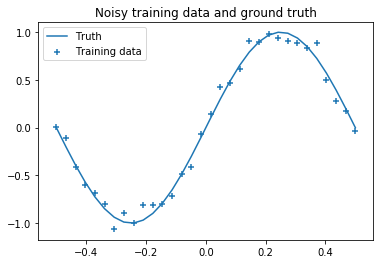

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return  np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 0.1

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import normalize  # noqa: F401
import torch.nn.functional as F

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal, Bernoulli  # noqa: F401
from pyro.infer import SVI,Trace_ELBO
from pyro.optim import Adam



pyro.get_param_store().clear()

In [4]:
X_train, Y_train = torch.Tensor(X), torch.Tensor(y)                                     
X_test, Y_test = torch.Tensor(X), torch.Tensor(y)
data = torch.cat((X_train, Y_train), 1)

In [5]:
# get array of batch indices
def get_batch_indices(N, batch_size):
    all_batches = np.arange(0, N, batch_size)
    if all_batches[-1] != N:
        all_batches = list(all_batches) + [N]
    return all_batches

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        #x = self.hidden2(x)
        #x = F.relu(x)
        x = self.predict(x)
        return x

#first_layer = len(X_train.data.numpy()[0])
first_layer = 1
second_layer = 20

softplus = nn.Softplus()
regression_model = Net(first_layer, second_layer)
print('regression_model is',regression_model)

regression_model is Net(
  (hidden): Linear(in_features=1, out_features=20, bias=True)
  (hidden2): Linear(in_features=20, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)


In [6]:
def model(data):
    ## hidden layer
    mu = Variable(torch.zeros(second_layer, first_layer)).type_as(data)
    sigma = Variable(torch.ones(second_layer, first_layer)).type_as(data)
    bias_mu = Variable(torch.zeros(second_layer)).type_as(data)
    bias_sigma = Variable(torch.ones(second_layer)).type_as(data)
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    
    
    ## hidden layer2
    mu1 = Variable(torch.zeros(second_layer, second_layer)).type_as(data)
    sigma1 = Variable(torch.ones(second_layer, second_layer)).type_as(data)
    bias_mu1 = Variable(torch.zeros(second_layer)).type_as(data)
    bias_sigma1 = Variable(torch.ones(second_layer)).type_as(data)
    w_prior1, b_prior1 = Normal(mu1, sigma1), Normal(bias_mu1, bias_sigma1)
    
    ## output layer
    mu2 = Variable(torch.zeros(1, second_layer)).type_as(data)
    sigma2 = Variable(torch.ones(1, second_layer)).type_as(data)
    bias_mu2 = Variable(torch.zeros(1)).type_as(data)
    bias_sigma2 = Variable(torch.ones(1)).type_as(data)
    w_prior2, b_prior2 = Normal(mu2, sigma2), Normal(bias_mu2, bias_sigma2)    
    
    priors = {'hidden.weight': w_prior, 
              'hidden.bias': b_prior,
              'hidden2.weight': w_prior1,
              'hidden2.bias':b_prior1,
              'predict.weight': w_prior2,
              'predict.bias': b_prior2}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N, subsample=data):
        #x_data = data[:, :-1]
        #y_data = data[:, -1]
        x_data = data[:,0]
        y_data = data[:,1]
        x_data = x_data.view(len(x_data),-1)
        y_data = y_data.view(len(y_data),-1)
        #print('x_data is',x_data.shape)
        # run the regressor forward conditioned on inputs
        #print('prediction is',lifted_reg_model(x_data).shape)
        prediction_mean = lifted_reg_model(x_data).squeeze()
        #print('prediction_mean.shape is',prediction_mean.shape)
        pyro.sample("obs",
                    Normal(prediction_mean, Variable(noise*torch.ones(data.size(0))).type_as(data)),
                    obs=y_data.squeeze())
        

def guide(data):
    #####################
    #hidden layer1
    w_mu = Variable(torch.randn(second_layer, first_layer).type_as(data.data), requires_grad=True)
    w_log_sig = Variable(0.1 * torch.ones(second_layer, first_layer).type_as(data.data), requires_grad=True)
    b_mu = Variable(torch.randn(second_layer).type_as(data.data), requires_grad=True)
    b_log_sig = Variable(0.1 * torch.ones(second_layer).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    
    # gaussian guide distributions for w and b
    w_dist = Normal(mw_param, sw_param)
    b_dist = Normal(mb_param, sb_param)
    ######################
    #hidden layer 2
    w_mu1 = Variable(torch.randn(second_layer, second_layer).type_as(data.data), requires_grad=True)
    w_log_sig1 = Variable(0.1 * torch.ones(second_layer, second_layer).type_as(data.data), requires_grad=True)
    b_mu1 = Variable(torch.randn(second_layer).type_as(data.data), requires_grad=True)
    b_log_sig1 = Variable(0.1 * torch.ones(second_layer).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param1 = pyro.param("guide_mean_weight1", w_mu1)
    sw_param1 = softplus(pyro.param("guide_log_sigma_weight1", w_log_sig1))
    mb_param1 = pyro.param("guide_mean_bias1", b_mu1)
    sb_param1 = softplus(pyro.param("guide_log_sigma_bias1", b_log_sig1))
    
    # gaussian guide distributions for w and b
    w_dist1 = Normal(mw_param1, sw_param1)
    b_dist1 = Normal(mb_param1, sb_param1)
    ######################
    # output layer
    w_mu2 = Variable(torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    w_log_sig2 = Variable(0.1 * torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    b_mu2 = Variable(torch.randn(1).type_as(data.data), requires_grad=True)
    b_log_sig2 = Variable(0.1 * torch.ones(1).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param2 = pyro.param("guide_mean_weight2", w_mu2)
    sw_param2 = softplus(pyro.param("guide_log_sigma_weight2", w_log_sig2))
    mb_param2 = pyro.param("guide_mean_bias2", b_mu2)
    sb_param2 = softplus(pyro.param("guide_log_sigma_bias2", b_log_sig2))
    
    # gaussian guide distributions for w and b
    w_dist2 = Normal(mw_param2, sw_param2)
    b_dist2 = Normal(mb_param2, sb_param2)
      
    dists = {'hidden.weight': w_dist, 
              'hidden.bias': b_dist,
             #'hidden.weight1':w_dist1,
             #'hidden.bias1':b_dist1,
              'predict.weight': w_dist2,
              'predict.bias': b_dist2}
    
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", regression_model, dists)
    # sample a regressor
    return lifted_module()

In [7]:
# instantiate optim and inference objects
optim = Adam({"lr": 0.03})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

N = len(X_train)

print(model(data))
print(guide(data))
for j in range(1500):
    epoch_loss = 0.0
    perm = torch.randperm(N)
    # shuffle data
    data = data[perm]
    # get indices of each batch
    all_batches = get_batch_indices(N, train_size)
    for ix, batch_start in enumerate(all_batches[:-1]):
        batch_end = all_batches[ix + 1]
        batch_data = data[batch_start: batch_end]
        #print('batch_data is',batch_data)
        epoch_loss += svi.step(batch_data)
    if j % 100 == 0:
        print(j, "avg loss {}".format(epoch_loss/float(N)))

None
Net(
  (hidden): Linear(in_features=1, out_features=20, bias=True)
  (hidden2): Linear(in_features=20, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)


RuntimeError: site module$$$hidden2.weight must be sample in trace
              Trace Shapes:        
               Param Sites:        
              Sample Sites:        
module$$$hidden.weight dist 20  1 |
                      value 20  1 |
  module$$$hidden.bias dist    20 |
                      value    20 |

In [ ]:
preds = []
for i in range(500):
    sampled_reg_model = guide(X_test)
    pred = sampled_reg_model(X_test).data.numpy().flatten()
    preds.append(pred)

preds = np.array(preds)
print('preds is',preds.shape)
mean = np.mean(preds, axis=0)
print('mean is',mean.shape)
std = np.std(preds, axis=0)
#mean = np.reshape(mean,(len(mean),1))
#std = np.reshape(std,(len(std),1))
x_test = X_test.data.numpy()[:,0]
print('x_test is',x_test.shape)
y_test = Y_test.data.numpy()[:,0]
#x = np.arange(len(y_test))

#plt.figure()
#plt.plot(original)
#plt.plot(predicted, linestyle = '--')
#plt.show()

plt.figure()
plt.scatter(x_test, y_test)
plt.plot(x_test, mean, linestyle = '--')
plt.fill_between(x_test, mean-2*std, mean+2*std, alpha = 0.3, color = 'orange')
plt.show()

In [ ]:
#for name in pyro.get_param_store().get_all_param_names():
    #print name, pyro.param(name).data.numpy()

In [ ]:
#plt.figure()
#plt.plot(out_weights)
#plt.plot(pyro.param('guide_mean_weight2').data.numpy()[0])
#plt.show()

In [ ]:
#plt.figure()
#plt.plot(dense_weights.T[14])
#plt.plot(pyro.param('guide_mean_weight').data.numpy()[10])
#plt.show()

In [ ]:
#print out_weights.mean(), out_weights.std()
#print pyro.param('guide_mean_weight2').data.numpy()[0].mean(), pyro.param('guide_mean_weight2').data.numpy()[0].mean()